In [1]:
# Importacao de bibliotecas

# Biblioteca para manipulacao de arquivos
import os

# Bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# Biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

# Biblioteca para implementar uma barra de progresso
import progressbar

# Utilitario de GPU
from numba import cuda

# Bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, GRU, Bidirectional, Dense

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

2023-06-23 15:46:18.834702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 15:46:19.986735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Checa a GPU e limpa ela
device = cuda.get_current_device()
print(device)
device.reset()

!nvidia-smi

<CUDA device 0 'b'NVIDIA GeForce 930M''>
/bin/bash: /home/arturfpc/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Fri Jun 23 15:46:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce 930M            Off | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0              N/A / 200W |      6MiB /  2048MiB |      2%      Default |
|   

In [3]:
# Criando diretório "models" se não existir

if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('models'):
    os.makedirs('models')

In [4]:
col_names = ['data','precoReal','precoDolar']

# Importação de dados
data = pd.read_csv('dataset/cafeArabica.csv', header=0, names=col_names, sep=';')

# Remove as colunas nao usadas
data = data.drop('data', axis=1)
data = data.drop('precoReal', axis=1)


# Converte tudo para número
data['precoDolar'] = data['precoDolar'].astype("float32")

x_names = 'precoDolar'

# Ajustando o dataset para treinamento com o keras
serie = data['precoDolar'].values.reshape(-1, 1)

print(serie.shape)

(6672, 1)


In [5]:
# Parametros
norm_method = 'none' 
range_adjust = (0,1)

# Café arábica ------
size_hist_window = 20 
size_forw_window = 10

# Realizar ajuste dos dados
data_adjust_exec = True

# Exportar os datasets tratados
export_frames = True

# Gerar um novo modelo ou usar um pronto
new_model = True

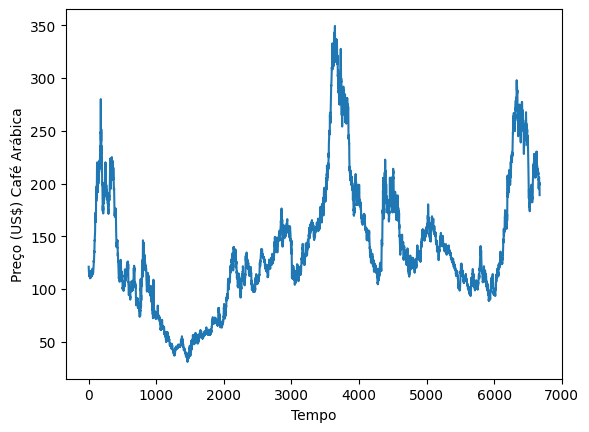

In [6]:
plt.plot(serie)
plt.xlabel("Tempo")
plt.ylabel("Preço (US$) Café Arábica")
plt.show()

In [7]:
def sumarizacao(serie, column):
    stats = []

    maximum = round(np.max(serie), 2)
    minimum = round(np.min(serie), 2)
    mean = round(np.mean(serie), 2)
    median = round(np.median(serie), 2)
    std = round(np.std(serie), 2)
    stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)

In [8]:
sumarizacao(serie, x_names)

| Coluna     |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:-----------|---------:|---------:|--------:|----------:|----------------:|
| precoDolar |   349.39 |    30.92 |  138.15 |    127.04 |           60.04 |


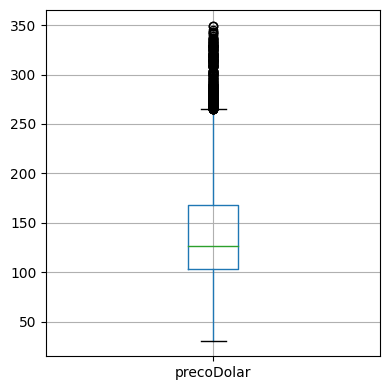

In [9]:
data.boxplot(column=x_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

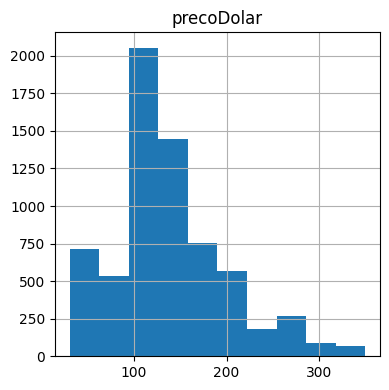

In [10]:
data.hist(column=x_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

In [12]:
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo:")
print(missing_counts)

Total de dados faltantes por atributo:
precoDolar    0
dtype: int64


In [13]:
def varianceEstabilization(serie, method):
    if method == 'asinh':
        return np.arcsinh(serie)
    elif method == 'log':
        return np.log(serie)
    else:
        return serie
    
def inverseVarianceEstabilization(serie, method):
    if method == 'asinh':
        return np.sinh(serie)
    elif method == 'log':
        return np.exp(serie)
    else:
        return serie

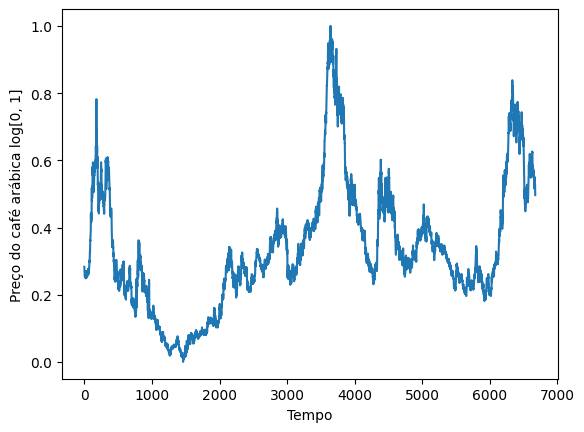

In [14]:
# Ajuste de dados
if data_adjust_exec:
    serie = varianceEstabilization(serie, norm_method)
    scaler = MinMaxScaler(feature_range=range_adjust)
    serie = scaler.fit_transform(serie)
    
plt.plot(serie)
plt.xlabel("Tempo")
plt.ylabel("Preço do café arábica log[0, 1]")
plt.show()

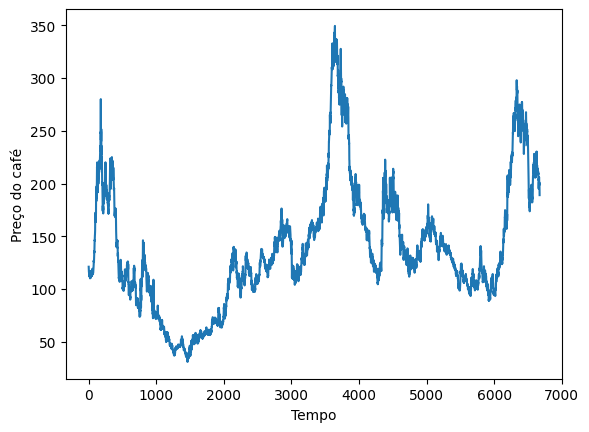

In [15]:
# Desconversao de dados
serie_original = scaler.inverse_transform(serie)
serie_original = inverseVarianceEstabilization(serie_original, norm_method)

plt.plot(serie_original)
plt.xlabel("Tempo")
plt.ylabel("Preço do café")
plt.show()

In [16]:
# Separa os conjuntos de treino/validacao e teste
trainval_size = int(len(serie) * 0.70)
test_size = len(serie) - trainval_size
trainval, test = serie[0:trainval_size,:], serie[trainval_size:len(serie),:]

print(trainval.shape)
print(test.shape)

(4670, 1)
(2002, 1)


In [17]:
# Cria os frames com base numa janela historica de dados
def create_frames(serie, back_window_size, forw_window_size):
    x_frames, y_frames = [], []
    
    for i in range(0, len(serie) - back_window_size - 1, forw_window_size):
        x_frames.append(serie[i:(i + back_window_size), 0])
        y_frames.append(serie[(i + back_window_size):(i + back_window_size) + forw_window_size, 0])
        
    return np.array(x_frames), np.array(y_frames)

In [18]:
# Cria os frames
def create_frames(data, size_hist_window, size_forw_window):
    x_frames = []
    y_frames = []
    for i in range(len(data) - size_hist_window - size_forw_window + 1):
        x_frames.append(data[i:i+size_hist_window])
        y_frames.append(data[i+size_hist_window:i+size_hist_window+size_forw_window])
    return np.array(x_frames, dtype=object), np.array(y_frames, dtype=object)

x_trainval, y_trainval = create_frames(trainval, size_hist_window, size_forw_window)
x_test, y_test = create_frames(test, size_hist_window, size_forw_window)

print(x_trainval.shape)
print(y_trainval.shape)
print(x_test.shape)
print(y_test.shape)

(4641, 20, 1)
(4641, 10, 1)
(1973, 20, 1)
(1973, 10, 1)


In [19]:
serie[0:13]

array([[0.2833234 ],
       [0.27245897],
       [0.27167395],
       [0.26834553],
       [0.26708955],
       [0.26435772],
       [0.2631017 ],
       [0.2544039 ],
       [0.2591767 ],
       [0.2603699 ],
       [0.2617201 ],
       [0.26671273],
       [0.2642949 ]], dtype=float32)

In [20]:
x_trainval[0:3]

array([[[0.28332340717315674],
        [0.2724589705467224],
        [0.27167394757270813],
        [0.26834553480148315],
        [0.2670895457267761],
        [0.26435771584510803],
        [0.2631016969680786],
        [0.25440388917922974],
        [0.25917670130729675],
        [0.2603698968887329],
        [0.26172009110450745],
        [0.2667127251625061],
        [0.26429489254951477],
        [0.260118693113327],
        [0.25883129239082336],
        [0.25971049070358276],
        [0.2609979212284088],
        [0.2605583071708679],
        [0.25845450162887573],
        [0.2570100724697113]],

       [[0.2724589705467224],
        [0.27167394757270813],
        [0.26834553480148315],
        [0.2670895457267761],
        [0.26435771584510803],
        [0.2631016969680786],
        [0.25440388917922974],
        [0.25917670130729675],
        [0.2603698968887329],
        [0.26172009110450745],
        [0.2667127251625061],
        [0.26429489254951477],
        [0.2601186931

In [21]:
y_trainval[0:3]

array([[[0.2487204372882843],
        [0.2529594898223877],
        [0.2541212737560272],
        [0.2608723044395447],
        [0.2698841392993927],
        [0.26825132966041565],
        [0.27000975608825684],
        [0.26765474677085876],
        [0.2687223255634308],
        [0.2627563178539276]],

       [[0.2529594898223877],
        [0.2541212737560272],
        [0.2608723044395447],
        [0.2698841392993927],
        [0.26825132966041565],
        [0.27000975608825684],
        [0.26765474677085876],
        [0.2687223255634308],
        [0.2627563178539276],
        [0.2615317106246948]],

       [[0.2541212737560272],
        [0.2608723044395447],
        [0.2698841392993927],
        [0.26825132966041565],
        [0.27000975608825684],
        [0.26765474677085876],
        [0.2687223255634308],
        [0.2627563178539276],
        [0.2615317106246948],
        [0.2576066851615906]]], dtype=object)

In [22]:
# Ajustando para atender aos requisitos de entrada da LSTM: (amostras, timesteps, features)
x_trainval = np.expand_dims(x_trainval, axis=2)
y_trainval = np.expand_dims(y_trainval, axis=2)
x_test = np.expand_dims(x_test, axis=2)
y_test = np.expand_dims(y_test, axis=2)

print(x_trainval.shape)
print(y_trainval.shape)
print(x_test.shape)
print(y_test.shape)

(4641, 20, 1, 1)
(4641, 10, 1, 1)
(1973, 20, 1, 1)
(1973, 10, 1, 1)


In [23]:
# CRIAÇÃO DO MODELO BASEADO EM LSTM

# Configurações de neurônios
units_lstm1 = 16
units_lstm2 = 32
units_lstm3 = 32
units_dense = 16

# Funções de ativação
actfunc_lstm1 = 'tanh'
actfunc_lstm2 = 'tanh'
actfunc_lstm3 = 'tanh'
actfunc_dense = 'tanh'
actfunc_output = 'tanh'

# Inicializador
initializer = tensorflow.keras.initializers.LecunNormal(seed=42)

# Criação das entradas de treino+validação
inputs = Input(shape=(x_trainval.shape[1], x_trainval.shape[2]), name="x_train")

# Camada LSTM 1
layer_lstm1 = LSTM(units_lstm1, 
                     activation=actfunc_lstm1, 
                     return_sequences=True,
                     kernel_initializer=initializer)(inputs)

# Camada LSTM 2
layer_lstm2 = LSTM(units_lstm2, 
                     activation=actfunc_lstm2, 
                     return_sequences=True,
                     kernel_initializer=initializer)(layer_lstm1)

# Camada LSTM 3
layer_lstm3 = Bidirectional(LSTM(units_lstm3, 
                                 activation=actfunc_lstm3, 
                                 return_sequences=False,
                                 kernel_initializer=initializer))(layer_lstm2)

# Camada densa final para ajustar o formato da saída
layer_dense = Dense(units_dense, activation=actfunc_dense)(layer_lstm3)

# Camada densa final para ajustar o formato da saída
layer_dense_out = Dense(y_trainval.shape[1], activation=actfunc_output)(layer_dense)

# Criação do modelo
model_trained = Model(inputs=inputs, outputs=layer_dense_out)

2023-06-23 15:54:42.465039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-23 15:54:42.509042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-23 15:54:42.509640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [24]:
model_trained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_train (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 16)            1152      
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            6272      
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                             

In [26]:
plot_model(model_trained, show_shapes=True, show_layer_names=True, rankdir="LR")  #TB para plotar na vertical

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
if new_model:
    es = EarlyStopping(monitor='val_loss', mode='min', patience=200)
    cp = ModelCheckpoint(filepath='models/best_weights.h5', 
                         save_weights_only=True, 
                         monitor='val_loss', 
                         mode='min', 
                         save_best_only=True)
    
    opt = Adam(learning_rate=0.0001)
    model_trained.compile(optimizer=opt, loss='mean_squared_error')

    x_trainval = np.asarray(x_trainval, dtype=np.float32)
    y_trainval = np.asarray(y_trainval, dtype=np.float32)

    history = model_trained.fit(x_trainval, 
                               y_trainval, 
                               validation_split=0.2,  # 20% para validação
                               epochs=1000, 
                               verbose=1, 
                               callbacks=[cp, es], 
                               batch_size=16, 
                               shuffle=False)
    
    np.save('models/history_model.npy', history.history)
    model_trained.load_weights('models/best_weights.h5')
    model_trained.save('models/rnn_cafe.h5')
else:
    model_trained = load_model('models/rnn_cafe.h5')

Epoch 1/1000


2023-06-23 15:55:00.750803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 15:55:00.753555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 15:55:00.755775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-23 15:55:04.248322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-23 15:55:04.340028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 15:55:04.344514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

232/232 [==============================] - ETA: 0s - loss: 0.0733

2023-06-23 15:55:11.423039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 15:55:11.425676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 15:55:11.427757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

232/232 [==============================] - 13s 19ms/step - loss: 0.0733 - val_loss: 0.0574
Epoch 2/1000
232/232 [==============================] - 3s 12ms/step - loss: 0.0221 - val_loss: 0.0255
Epoch 3/1000
232/232 [==============================] - 3s 11ms/step - loss: 0.0125 - val_loss: 0.0166
Epoch 4/1000
232/232 [==============================] - 3s 12ms/step - loss: 0.0084 - val_loss: 0.0127
Epoch 5/1000
232/232 [==============================] - 3s 14ms/step - loss: 0.0063 - val_loss: 0.0108
Epoch 6/1000
232/232 [==============================] - 3s 12ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 7/1000
232/232 [==============================] - 3s 11ms/step - loss: 0.0043 - val_loss: 0.0099
Epoch 8/1000
232/232 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0101
Epoch 9/1000
232/232 [==============================] - 2s 10ms/step - loss: 0.0035 - val_loss: 0.0102
Epoch 10/1000
232/232 [==============================] - 2s 10ms/step - loss: 0.0032 

232/232 [==============================] - 3s 12ms/step - loss: 8.9620e-04 - val_loss: 0.0054
Epoch 80/1000
232/232 [==============================] - 3s 11ms/step - loss: 8.9128e-04 - val_loss: 0.0054
Epoch 81/1000
232/232 [==============================] - 3s 11ms/step - loss: 8.8647e-04 - val_loss: 0.0053
Epoch 82/1000
232/232 [==============================] - 3s 11ms/step - loss: 8.8179e-04 - val_loss: 0.0053
Epoch 83/1000
232/232 [==============================] - 3s 11ms/step - loss: 8.7723e-04 - val_loss: 0.0052
Epoch 84/1000
232/232 [==============================] - 3s 11ms/step - loss: 8.7279e-04 - val_loss: 0.0052
Epoch 85/1000
232/232 [==============================] - 3s 11ms/step - loss: 8.6846e-04 - val_loss: 0.0052
Epoch 86/1000
232/232 [==============================] - 3s 11ms/step - loss: 8.6425e-04 - val_loss: 0.0052
Epoch 87/1000
232/232 [==============================] - 3s 11ms/step - loss: 8.6015e-04 - val_loss: 0.0051
Epoch 88/1000
232/232 [===================

232/232 [==============================] - 3s 11ms/step - loss: 7.3316e-04 - val_loss: 0.0038
Epoch 155/1000
232/232 [==============================] - 3s 11ms/step - loss: 7.3124e-04 - val_loss: 0.0038
Epoch 156/1000
232/232 [==============================] - 3s 11ms/step - loss: 7.3069e-04 - val_loss: 0.0038
Epoch 157/1000
232/232 [==============================] - 3s 11ms/step - loss: 7.3964e-04 - val_loss: 0.0039
Epoch 158/1000
232/232 [==============================] - 3s 11ms/step - loss: 7.2785e-04 - val_loss: 0.0037
Epoch 159/1000
232/232 [==============================] - 3s 11ms/step - loss: 7.2371e-04 - val_loss: 0.0037
Epoch 160/1000
232/232 [==============================] - 3s 11ms/step - loss: 7.4593e-04 - val_loss: 0.0040
Epoch 161/1000
232/232 [==============================] - 3s 11ms/step - loss: 7.1670e-04 - val_loss: 0.0035
Epoch 162/1000
232/232 [==============================] - 3s 11ms/step - loss: 7.3051e-04 - val_loss: 0.0039
Epoch 163/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 6.9187e-04 - val_loss: 0.0034
Epoch 230/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.9818e-04 - val_loss: 0.0034
Epoch 231/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.8642e-04 - val_loss: 0.0032
Epoch 232/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.9268e-04 - val_loss: 0.0034
Epoch 233/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.8333e-04 - val_loss: 0.0033
Epoch 234/1000
232/232 [==============================] - 3s 11ms/step - loss: 7.0145e-04 - val_loss: 0.0035
Epoch 235/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.8460e-04 - val_loss: 0.0032
Epoch 236/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.9460e-04 - val_loss: 0.0034
Epoch 237/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.7848e-04 - val_loss: 0.0032
Epoch 238/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 6.6824e-04 - val_loss: 0.0032
Epoch 305/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.8616e-04 - val_loss: 0.0033
Epoch 306/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.5721e-04 - val_loss: 0.0029
Epoch 307/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.5535e-04 - val_loss: 0.0031
Epoch 308/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.7460e-04 - val_loss: 0.0033
Epoch 309/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.6831e-04 - val_loss: 0.0031
Epoch 310/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.5782e-04 - val_loss: 0.0031
Epoch 311/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.6499e-04 - val_loss: 0.0032
Epoch 312/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.7051e-04 - val_loss: 0.0032
Epoch 313/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 6.3065e-04 - val_loss: 0.0029
Epoch 380/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.5218e-04 - val_loss: 0.0033
Epoch 381/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.8307e-04 - val_loss: 0.0031
Epoch 382/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.5119e-04 - val_loss: 0.0028
Epoch 383/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.3025e-04 - val_loss: 0.0029
Epoch 384/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.5499e-04 - val_loss: 0.0031
Epoch 385/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.3147e-04 - val_loss: 0.0028
Epoch 386/1000
232/232 [==============================] - 3s 12ms/step - loss: 6.2523e-04 - val_loss: 0.0030
Epoch 387/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.5802e-04 - val_loss: 0.0033
Epoch 388/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 6.2852e-04 - val_loss: 0.0028
Epoch 455/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.1107e-04 - val_loss: 0.0026
Epoch 456/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.0855e-04 - val_loss: 0.0027
Epoch 457/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.0777e-04 - val_loss: 0.0029
Epoch 458/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.1833e-04 - val_loss: 0.0029
Epoch 459/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.1288e-04 - val_loss: 0.0029
Epoch 460/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.2278e-04 - val_loss: 0.0030
Epoch 461/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.2015e-04 - val_loss: 0.0029
Epoch 462/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.1300e-04 - val_loss: 0.0027
Epoch 463/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 6.0355e-04 - val_loss: 0.0027
Epoch 530/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.0714e-04 - val_loss: 0.0028
Epoch 531/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.1049e-04 - val_loss: 0.0026
Epoch 532/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.9552e-04 - val_loss: 0.0025
Epoch 533/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.9023e-04 - val_loss: 0.0024
Epoch 534/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.9436e-04 - val_loss: 0.0026
Epoch 535/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.8921e-04 - val_loss: 0.0026
Epoch 536/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.9338e-04 - val_loss: 0.0026
Epoch 537/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.0565e-04 - val_loss: 0.0026
Epoch 538/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 5.8107e-04 - val_loss: 0.0023
Epoch 605/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.7611e-04 - val_loss: 0.0027
Epoch 606/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.9123e-04 - val_loss: 0.0026
Epoch 607/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.9935e-04 - val_loss: 0.0027
Epoch 608/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.9740e-04 - val_loss: 0.0026
Epoch 609/1000
232/232 [==============================] - 3s 11ms/step - loss: 6.0164e-04 - val_loss: 0.0021
Epoch 610/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.8449e-04 - val_loss: 0.0024
Epoch 611/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.7419e-04 - val_loss: 0.0025
Epoch 612/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.7794e-04 - val_loss: 0.0021
Epoch 613/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 5.7672e-04 - val_loss: 0.0020
Epoch 680/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.7330e-04 - val_loss: 0.0024
Epoch 681/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6839e-04 - val_loss: 0.0026
Epoch 682/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.9700e-04 - val_loss: 0.0024
Epoch 683/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.7641e-04 - val_loss: 0.0022
Epoch 684/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6493e-04 - val_loss: 0.0024
Epoch 685/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6364e-04 - val_loss: 0.0023
Epoch 686/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.7282e-04 - val_loss: 0.0022
Epoch 687/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.7178e-04 - val_loss: 0.0027
Epoch 688/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 5.8091e-04 - val_loss: 0.0019
Epoch 755/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.8241e-04 - val_loss: 0.0026
Epoch 756/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.8277e-04 - val_loss: 0.0022
Epoch 757/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.8369e-04 - val_loss: 0.0021
Epoch 758/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6426e-04 - val_loss: 0.0021
Epoch 759/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5811e-04 - val_loss: 0.0023
Epoch 760/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.7406e-04 - val_loss: 0.0021
Epoch 761/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.7217e-04 - val_loss: 0.0023
Epoch 762/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6117e-04 - val_loss: 0.0022
Epoch 763/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 5.5685e-04 - val_loss: 0.0022
Epoch 830/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5767e-04 - val_loss: 0.0022
Epoch 831/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6633e-04 - val_loss: 0.0021
Epoch 832/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6310e-04 - val_loss: 0.0023
Epoch 833/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5797e-04 - val_loss: 0.0022
Epoch 834/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5900e-04 - val_loss: 0.0022
Epoch 835/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5902e-04 - val_loss: 0.0021
Epoch 836/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6502e-04 - val_loss: 0.0023
Epoch 837/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6187e-04 - val_loss: 0.0021
Epoch 838/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 5.6058e-04 - val_loss: 0.0020
Epoch 905/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6465e-04 - val_loss: 0.0021
Epoch 906/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.4964e-04 - val_loss: 0.0021
Epoch 907/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5154e-04 - val_loss: 0.0020
Epoch 908/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5220e-04 - val_loss: 0.0020
Epoch 909/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5873e-04 - val_loss: 0.0022
Epoch 910/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5694e-04 - val_loss: 0.0020
Epoch 911/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.6114e-04 - val_loss: 0.0023
Epoch 912/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5267e-04 - val_loss: 0.0021
Epoch 913/1000
232/232 [==========

232/232 [==============================] - 3s 11ms/step - loss: 5.4996e-04 - val_loss: 0.0020
Epoch 980/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5458e-04 - val_loss: 0.0021
Epoch 981/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5047e-04 - val_loss: 0.0021
Epoch 982/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5790e-04 - val_loss: 0.0021
Epoch 983/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.4774e-04 - val_loss: 0.0021
Epoch 984/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5517e-04 - val_loss: 0.0020
Epoch 985/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.4960e-04 - val_loss: 0.0021
Epoch 986/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.5636e-04 - val_loss: 0.0021
Epoch 987/1000
232/232 [==============================] - 3s 11ms/step - loss: 5.4805e-04 - val_loss: 0.0021
Epoch 988/1000
232/232 [==========

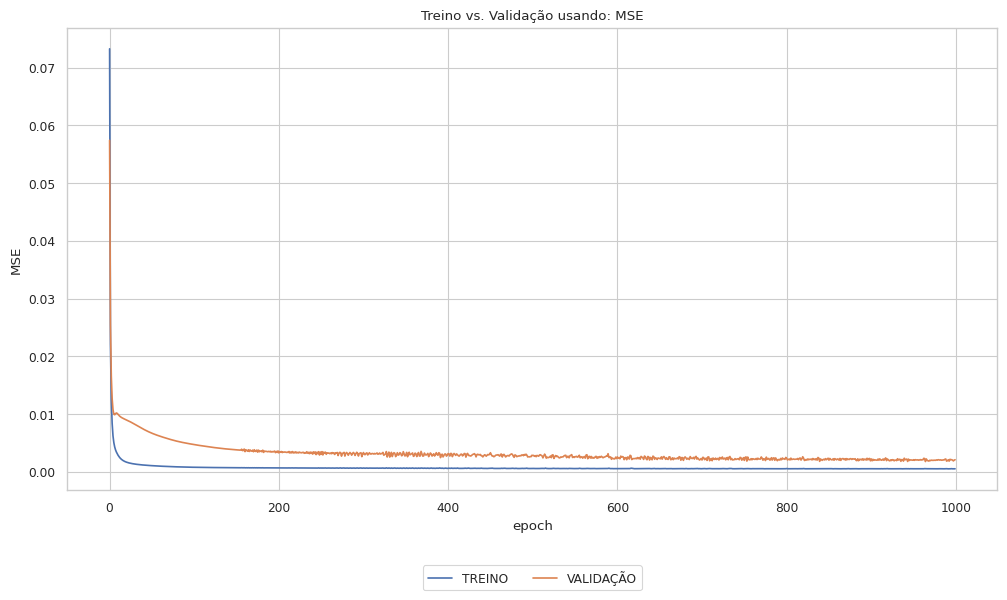

In [26]:
history=np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'mse'

fig = plt.figure()

plt.plot(train_metric, label='TREINO'), 
plt.plot(valid_metric, label='VALIDAÇÃO')
plt.ylabel(name_metric.upper())
plt.xlabel('epoch')
plt.title('Treino vs. Validação usando: ' + name_metric.upper())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

In [27]:
test[0:13]

array([[0.330455  ],
       [0.33613843],
       [0.32188272],
       [0.33340663],
       [0.32508555],
       [0.328728  ],
       [0.31915095],
       [0.326687  ],
       [0.32150596],
       [0.32979557],
       [0.32913622],
       [0.3263416 ],
       [0.3246774 ]], dtype=float32)

In [28]:
x_test[0:1]

array([[[[0.3304550051689148]],

        [[0.33613842725753784]],

        [[0.3218827247619629]],

        [[0.33340662717819214]],

        [[0.3250855505466461]],

        [[0.32872799038887024]],

        [[0.3191509544849396]],

        [[0.3266870081424713]],

        [[0.32150596380233765]],

        [[0.32979556918144226]],

        [[0.3291362226009369]],

        [[0.3263415992259979]],

        [[0.32467740774154663]],

        [[0.3241749703884125]],

        [[0.3143467307090759]],

        [[0.31525734066963196]],

        [[0.3108927011489868]],

        [[0.3054291009902954]],

        [[0.30395328998565674]],

        [[0.30307409167289734]]]], dtype=object)

In [29]:
y_test[0:1]

array([[[[0.3034195005893707]],

        [[0.31111252307891846]],

        [[0.3197789192199707]],

        [[0.32549378275871277]],

        [[0.3214431405067444]],

        [[0.3181147277355194]],

        [[0.31302791833877563]],

        [[0.3069362938404083]],

        [[0.31111252307891846]],

        [[0.3042672872543335]]]], dtype=object)

In [30]:
y_true = scaler.inverse_transform(y_test.reshape(y_test.flatten().shape[0],1))
y_true = inverseVarianceEstabilization(y_true, norm_method).flatten()
y_true.shape

(19730,)

In [31]:
# Converte para um formato compatível

x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [32]:
# Realiza as previsoes do modelo treinado no conjunto de testes e volta para a escala original

y_hat = model_trained.predict(x_test)

2023-06-23 17:34:46.579880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 17:34:46.581943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 17:34:46.583631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

62/62 [==============================] - 2s 6ms/step


In [33]:
# Pega os dados previstos e coloca na escala original

y_hat = scaler.inverse_transform(y_hat)
y_hat = inverseVarianceEstabilization(y_hat, norm_method).flatten()
y_hat.shape

(19730,)

In [34]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def printRegressionMetrics(y_true, y_pred):
    
    MAPE = mape(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    
    print('MAPE:')
    print(MAPE)
    print('R2:')
    print(R2)

In [35]:
printRegressionMetrics(y_true, y_hat)

MAPE:
4.757597809829326
R2:
0.9679374571605378


In [36]:
# Pega os valores reais anteriores ao ponto de previsao 

y_true_trainval = y_trainval.flatten().reshape(len(y_trainval.flatten()),1)
y_true_trainval = scaler.inverse_transform(y_true_trainval)
y_true_trainval = inverseVarianceEstabilization(y_true_trainval, norm_method).flatten()
y_true_trainval.shape

(46410,)

In [37]:
# Cria um data table com os valores reais e preditos

df_forecast = pd.DataFrame()
df_forecast['y_true'] = np.hstack((y_true_trainval, y_true))
df_forecast['y_hat'] = np.hstack((y_true_trainval, y_hat))

df_forecast.shape

(66140, 2)

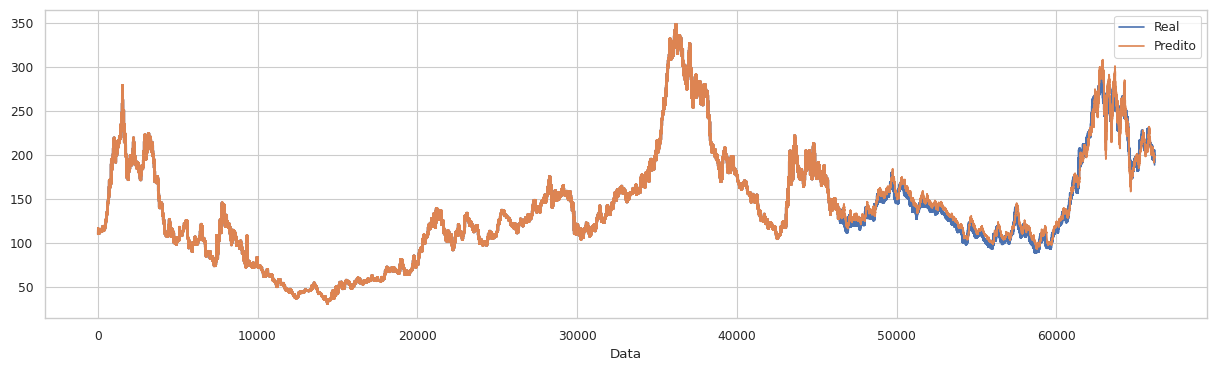

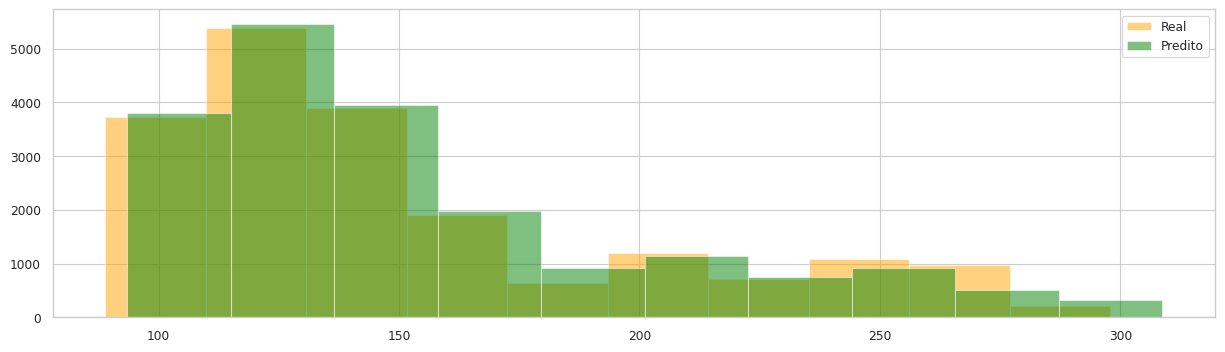

In [38]:
sns.set(rc={'figure.figsize':(15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

ax = df_forecast.plot(x_compat=True, style='-')
ax.set_xlabel("Data")
ax.legend(["Real", "Predito"])

plt.grid(True)

plt.show()

plt.close()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(figsize=(15, 4))
plt.hist(y_true, bins=10, color='orange', alpha=0.5, label='Real')
plt.hist(y_hat, bins=10, color='green', alpha=0.5, label='Predito')
plt.legend()

plt.show()

plt.close()

In [37]:
y_true.astype(float)

array([409.93999974, 411.59999959, 415.93001018, ..., 950.54999937,
       917.44999386, 901.57003906])

In [38]:
y_hat.astype(float)

array([412.86245728, 367.33795166, 402.84338379, ..., 591.75146484,
       510.89654541, 577.67407227])